In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(20061, 28)
(20061, 2)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149, 0.0, 0.0, -0.0575137704686, 0.0700262483306,
       -0.0177582072335, 0.00282305354852, 0.00383982704313,
       0.0149367574186, -0.394622782974, 0.0470562756282,
       0.000190880443402, -0.0143910438763, 0.410776979039,
       -0.000293245359969, -0.0140386821078, -0.392070472035,
       0.000263396218383, 0.407262437373, -0.0250143312816,
       -0.000161031301815, True, False, False, True, 0.10000000149, 0.0,
       0.0], dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.024368676025119385, -0.007677743332976661], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(10026, 28)
(10026, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :]

array([0.0, 0.0, 0.0, -0.0198547262136, -0.0172423022875,
       -0.0198557445068, -0.000355525708131, 0.00039015890341,
       -0.0136726530603, -0.0709083103244, -0.403899813181,
       0.000283498045823, -0.390653663325, 0.0213596803198,
       -0.000431321637429, 0.411711617417, -0.0232815178283,
       0.000252624577357, 0.0469591834389, 0.392683234106,
       -0.000107462204972, False, True, True, False, 0.0, 0.0, 0.0],
      dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.001440723119287668, 0.005183147870496896], dtype=object)

### Linear Regression

In [13]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9584331449707865
RMSE:  0.008143151506716248
The lowest error is:  3.257340148707377e-06
The highest error is:  0.05887208074406615
The avg. error is:  0.00547411293743272


In [14]:
model_fr_com_x.coef_

array([[ 0.01009882, -0.00138146,  0.00591929,  0.1437222 , -0.00433467,
         0.00130813,  0.07772784,  0.16929027, -0.17838602,  0.00798173,
        -0.04074072,  0.04963839,  0.10051764,  0.03709051]])

In [15]:
model_fr_com_x.intercept_

array([0.00490574])

In [16]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[0.01347879]]


Text(0, 0.5, 'Predictions')

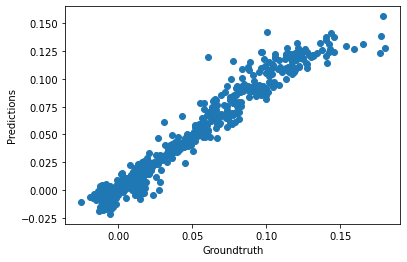

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#%store model_fr_com_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [19]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8962228446988567
RMSE:  0.008199723865279016
The lowest error is:  3.496793084263594e-06
The highest error is:  0.053360186798039146
The avg. error is:  0.005903292345221263


In [20]:
model_fr_com_y.coef_

array([[-0.00971856, -0.01017369,  0.00118772, -0.01158384,  0.15330004,
        -0.00105279, -0.11278145, -0.24258692, -0.02812024, -0.18596375,
        -0.09274634, -0.15458673, -0.07468321, -0.1887789 ]])

In [21]:
model_fr_com_y.intercept_

array([0.00334893])

Text(0, 0.5, 'Predictions')

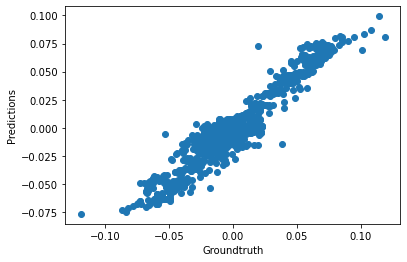

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [23]:
#%store model_fr_com_y

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")